In [3]:
import pandas as pd
import os

In [34]:
def read_csv_data(path, skip_first_row=True):
    """
    Reads the csv file from the given path 
    and returns a pandas dataframe.

    Input => str : file path
    Output => pd.DataFrame : data from the file
    """
    assert isinstance(path, str) and path[-3:] == "csv"

    try:
        df = pd.read_csv(path, skiprows=1 if skip_first_row else None)
    except:
        raise FileNotFoundError
    return df

### Disaster map

* Process dataset to get cost and frequency of disasters of each state

In [338]:
state_cost = read_csv_data(os.getcwd() + "/datasets/state-cost-data.csv")
state_cost.head()

,state,drought,flooding,freeze,severe storm,tropical cyclone,wildfire,winter storm
0,AK,0.0,0.0,0.0,0.0,0.0,2291.0,0.0
1,AL,6706.5,134.3,148.7,13758.5,26396.7,716.4,2372.7
2,AR,6580.0,4592.7,291.0,10084.0,703.3,0.0,1132.4
3,AZ,1455.5,1877.7,0.0,5358.0,0.0,1322.4,0.0
4,CA,16169.6,18772.4,15106.0,3445.4,0.0,97669.8,0.0


In [339]:
state_cost['cost'] = state_cost.iloc[:, 1:].sum(axis=1)
cost = state_cost[['state', 'cost']]
state_freq = read_csv_data(os.getcwd() + "/datasets/state-freq-data.csv")
state_freq['freq'] = state_freq.iloc[:, 2:].sum(axis=1)
freq = state_freq.groupby('state').freq.sum()
freq = freq.reset_index()

state_disaster = pd.merge(cost, freq, on = 'state')
state_disaster['cost'] = state_disaster['cost'] / 1000 # transfer to $billions
state_disaster.head()


* Use geopandas library to plot disaster distribution of US. 
* The geopandas library works with shapefiles. Shapefiles are a standardized format for geospatial data and can be pulled from a number of sources including the US Census website. We download shapefiles from https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_500k.zip

In [341]:
import geopandas as gpd
from geopandas import GeoDataFrame
gdf = gpd.read_file(os.getcwd()+"/datasets/cb_2022_us_state_500k")
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
1,46,01785534,0400000US46,46,SD,South Dakota,00,196341552329,3387681983,"POLYGON ((-104.05788 44.99761, -104.05078 44.9..."
2,06,01779778,0400000US06,06,CA,California,00,403673617862,20291712025,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."
3,21,01779786,0400000US21,21,KY,Kentucky,00,102266581101,2384240769,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ..."
4,01,01779775,0400000US01,01,AL,Alabama,00,131185042550,4582333181,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."


In [342]:
gdf = gdf.merge(state_disaster,left_on='STUSPS',right_on='state')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state,cost,freq
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48000, -109.04984 31.4...",NM,7.1620,36
1,46,01785534,0400000US46,46,SD,South Dakota,00,196341552329,3387681983,"POLYGON ((-104.05788 44.99761, -104.05078 44.9...",SD,21.5546,33
2,06,01779778,0400000US06,06,CA,California,00,403673617862,20291712025,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",CA,151.1632,46
3,21,01779786,0400000US21,21,KY,Kentucky,00,102266581101,2384240769,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ...",KY,27.0473,85
4,01,01779775,0400000US01,01,AL,Alabama,00,131185042550,4582333181,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",AL,50.2338,108


In [77]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from shapely.geometry import Polygon

In [78]:
# Apply this the gdf to ensure that all states are assigned colors by the same function
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

In [325]:
# Function to plot an US map with disaster distribution
def plot_disasters_map(gdf, variable, label, save_name):

    # make a column for value_determined_color in gdf
    # set the range for the choropleth values with the upper bound the rounded up maximum value
    vmin, vmax = gdf[variable].min(), gdf[variable].max()
    colormap = "YlOrBr"
    gdf = makeColorColumn(gdf,variable,vmin,vmax)

    # create "visframe" as a re-projected gdf using EPSG 2163
    visframe = gdf.to_crs({'init':'epsg:2163'})

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(24, 16))
    # remove the axis box around the vis
    ax.axis('off')

    # set the font for the visualization to Helvetica
    hfont = {'fontname':'Helvetica'}

    # add a title and annotation
    ax.set_title('Billion-Dollar Weather and Climate Disasters\n1980-2023', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'}, y=0.93)

    # Create colorbar legend
    fig = ax.get_figure()
    # add colorbar axes to the figure
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.75, 0.18, 0.03, 0.30])
    cbax.set_title(label, **hfont, fontdict={'fontsize': '26', 'fontweight' : '0'}, pad = 25)

    # add color scale
    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # reformat tick labels on legend
    sm._A = []
    comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
    fig.colorbar(sm, cax=cbax, format=comma_fmt)
    tick_font_size = 24
    cbax.tick_params(labelsize=tick_font_size)

    ax.annotate("Data: NOAA's Billion-Dollar Weather and Climate Disasters Database\nhttps://www.ncei.noaa.gov/access/billions/mapping", xy=(0.22, .085), xycoords='figure fraction', fontsize=16, color='#555555')


    # create map
    for row in visframe.itertuples():
        if row.state not in ['AK','HI']:
            vf = visframe[visframe.state==row.state]
            c = gdf[gdf.state==row.state][0:1].value_determined_color.item()
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')
            if row.state in ['TX', 'CA']:
                for idx, row in vf.iterrows():
                    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(int(row[variable])), fontsize=20, ha='center')


    # add Alaska
    akax = fig.add_axes([0.1, 0.17, 0.3, 0.19])   
    akax.axis('off')
    # polygon to clip western islands
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
    alaska_gdf = gdf[gdf.state=='AK']
    alaska_gdf.clip(polygon).plot(color=gdf[gdf.state=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


    # add Hawaii
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis('off')
    # polygon to clip western islands
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_gdf = gdf[gdf.state=='HI']
    hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')
    
    fig.savefig(os.getcwd()+save_name,dpi=400, bbox_inches="tight")

/Users/cocoa/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:68: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/Users/cocoa/anaconda3/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



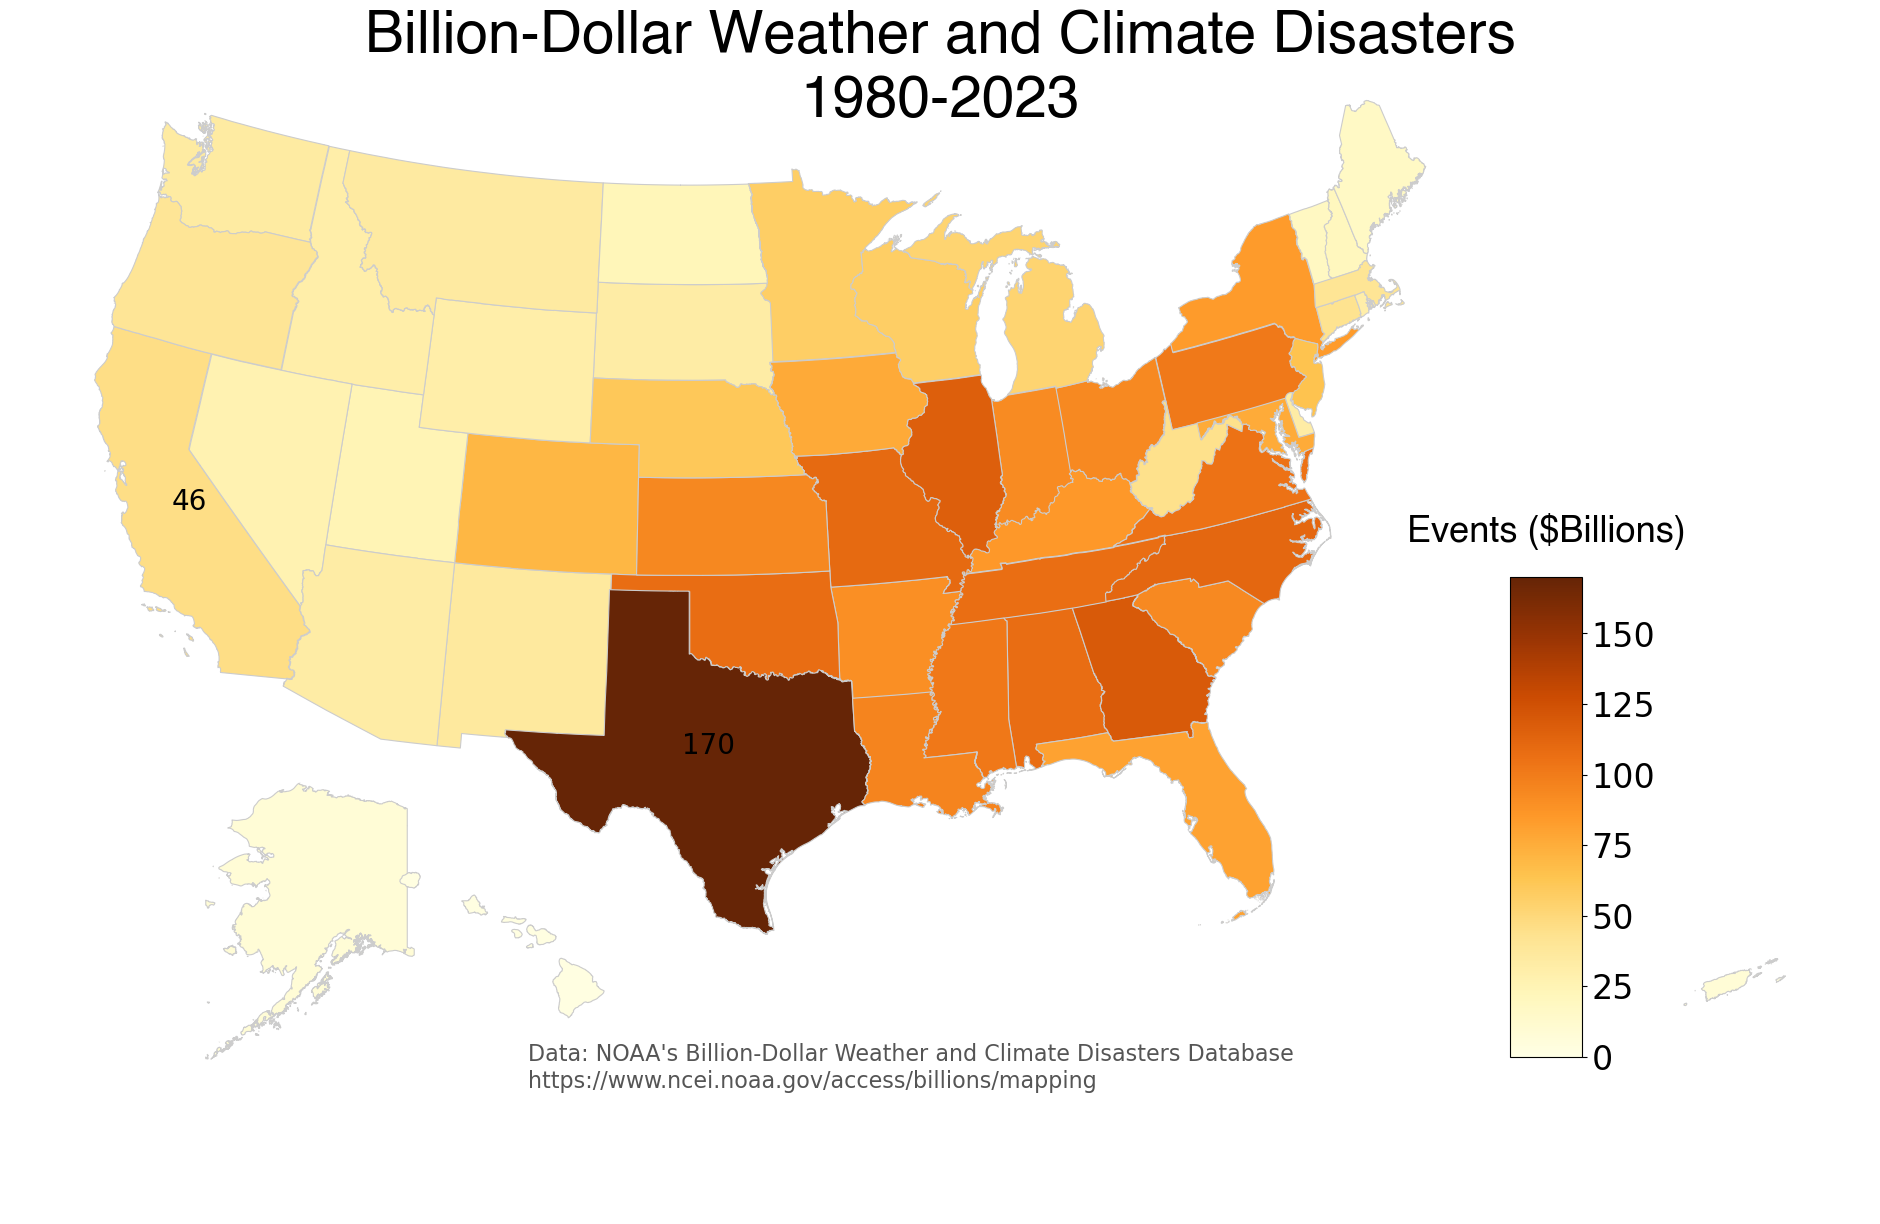

In [327]:
# Plot frequency distribution map
variable = 'freq'
label = 'Events ($Billions)'
save_name = '/disasters_frequency_by_state_1980_2023.png'
plot_disasters_map(gdf, variable, label, save_name)

/Users/cocoa/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:68: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/Users/cocoa/anaconda3/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



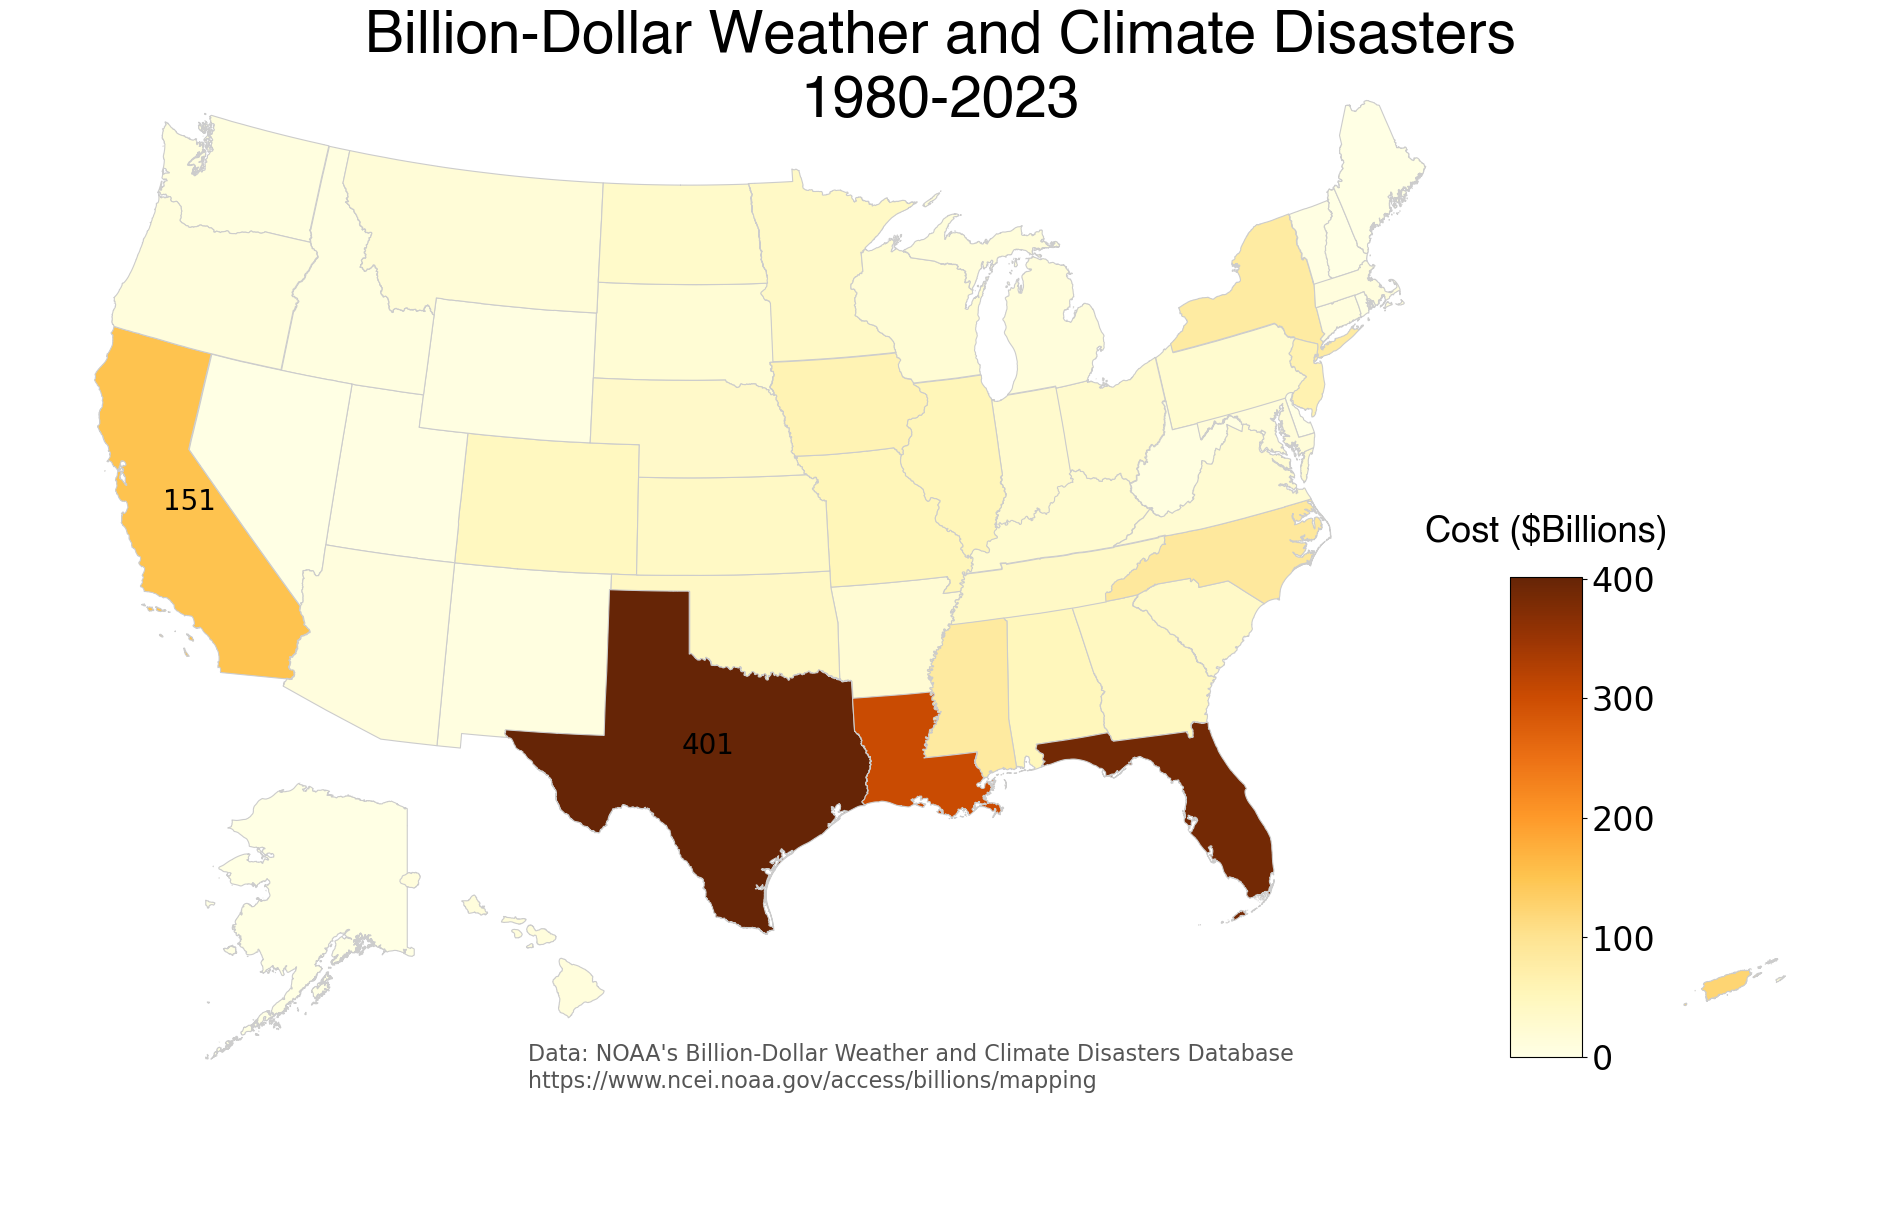

In [326]:
# Plot cost distribution map
variable = 'cost'
label = 'Cost ($Billions)'
save_name = '/disasters_cost_by_state_1980_2023.png'
plot_disasters_map(gdf, variable, label, save_name)

### Disaster types

In [343]:
import plotly.express as px

def plot_bar_chart(val, name, title, title_yaxis):
    x_labels=[]
    for label in name:
        x_labels.append(label.replace(' ','<br>'))
    fig = px.bar(x=x_labels, y=val, labels={'x':'', 'y':''}, title=title)
    fig.update_traces(marker_color='orange')
    fig.update_traces(text=val, textposition='outside', textfont = dict(size=14))
    fig.update_layout(
        title_font_size =30,
        title_x=0.5,
        xaxis=dict(
           tickfont=dict(size=16)),
        yaxis=dict(title=title_yaxis, titlefont_size=20, tickfont_size = 16, side='top'),
        height=500,
        width=700
    )
    fig.show()

In [344]:
# Process data to get cost of different types
state_cost = state_cost[~ (state_cost['state'] == 'US')]
type_cost = state_cost.iloc[:,1:].sum(axis=0)
types = type_cost.index.to_list()
types = types[:-1]
type_cost = list(type_cost)
type_cost = type_cost[:-1]
type_cost = [int(cost / 1000) for cost in type_cost ] # transfer to billions 

In [345]:
plot_bar_chart(type_cost, types, 'Cost of Different Disaster Types','Cost ($Billions)')

In [346]:
# Process data to get frequency of different types
disaster_dataset = read_csv_data(os.getcwd() + "/datasets/events-US-1980-2023.csv")
type_freq = disaster_dataset.groupby('Disaster')['Name'].count()
type_freq = list(type_freq)

In [347]:
plot_bar_chart(type_freq, types, 'Frequency of Different Disaster Types','Frequency')

### Disaster time trend

In [348]:
# Process data to get frequency and cost of different years
disaster_dataset['year'] = disaster_dataset['Begin Date'].astype(str).str[:4]
year_freq = disaster_dataset.groupby('year')['Name'].count()
year_list =year_freq.index.to_list()
year_freq = list(year_freq)

year_cost = disaster_dataset.groupby('year')['Total CPI-Adjusted Cost (Millions of Dollars)'].sum()
year_cost = list(year_cost)
year_cost = [int(cost / 1000) for cost in year_cost]


In [351]:
import plotly.graph_objects as go

fig = go.Figure()

# add bar chart 
fig.add_trace(go.Bar(x=year_list, y=year_cost, name='Cost($Billions)', marker_color='orange'))

# add scatter chart
fig.add_trace(go.Scatter(x=year_list,y=year_freq, mode='lines', name='Frequency', yaxis='y2',marker_color='blue'))

# update layout
fig.update_layout(
    title='Frequency and Cost of Disaster 1980-2023',
    title_font_size =30,
    title_x=0.5,
    xaxis=dict(title='Year',titlefont_size=20),
    yaxis=dict(title='Cost($Billions)', titlefont=dict(color='orange'),titlefont_size=20),
    yaxis2=dict(title='Frequency', titlefont=dict(color='blue'), overlaying='y', side='right',titlefont_size=20),
    height=500,
    width=1000,
    legend=dict(x=0.02, y=1.0)
)

fig.show()
